# Authored by Mohsen Ahmadkhani - ahmad178@umn.edu

## Zindi Competition

## Code for 2 submissions



In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
import ee
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt

Authenticate and initialize Earth Engine.

**You will need an Earth Engine account. It can be requested having a Google account at https://earthengine.google.com/**

You will be prompted to enter your credentials after running the lines below

In [94]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=_0jVzkKhlTJNEbfzvzmW3evUXjXCKGaHI28Wcwb4qOg&tc=O-7kE5pXsdWvSuVIds1i7SnV8fd7IWZ3v10apM6HY-0&cc=1x5O_Qk2kLy08ie5Ia-7CaUA6wMcCfTvC6lgqz966JI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXnpfsJRFSWOj2IwpJZ5qgt20TKRKklSrRFs0fKK6Jvi-ySr_RMsfCc

Successfully saved authorization token.


In [95]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [96]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [97]:
train = pd.read_csv('additional_data/new_train.csv')
train

,ID,Lat,Lon,Target
0,ID-AF-1-167,34.255219,70.355249,1
1,ID_MXSR6I2SI83T,14.512643,33.513448,0
2,ID-SU-1-137,14.485124,33.384548,1
3,ID_6LYQ4OF6LWA3,32.129414,48.189045,0
4,ID_1MX7EP89RDEM,32.324798,48.144220,1
...,...,...,...,...
2995,ID_BV0XPFOEAYDR,14.407809,33.372053,0
2996,ID_UJ3685FO4X0Y,32.213227,48.393592,1
2997,ID_WXV2996SCM9W,32.388398,48.339783,1
2998,ID-IR-0-46,32.452085,48.265079,0


In [98]:
test = pd.read_csv('Test.csv')
test

,ID,Lat,Lon
0,ID_9ZLHTVF6NSU7,34.254835,70.348699
1,ID_LNN7BFCVEZKA,32.009669,48.535526
2,ID_SOYSG7W04UH3,14.431884,33.399991
3,ID_EAP7EXXV8ZDE,14.281866,33.441224
4,ID_QPRX1TUQVGHU,14.399365,33.109566
...,...,...,...
1495,ID_6LVHE89NN5VE,34.077906,70.697531
1496,ID_M51GDSUBKS8Q,32.202177,48.344005
1497,ID_469MTLRKJC64,32.340069,48.157425
1498,ID_DMH9P3N6O3DK,14.260575,33.551627


# NOTE: Running this will use the data I downloaded previously.
# ... Continuing with this data set will produce exact same results as submitted.
# If you skip this cell, you will run the data collection step again that can cause very small differences in the dataset used.

## For generating identical results, skip all these cells until "Classification" part at the bottom of this notebook.

In [170]:
# NOTE: Running this will use the data I downloaded previously.
# ... Continuing with this data set will produce exact same results as submitted.
# If you skip this cell, you will run the data collection step again that can cause very small differences in the dataset used.

df_train = pd.read_csv('new_train_12mboth_lc.csv')
df_test = pd.read_csv('new_test_12mboth_lc.csv')

### For downloading and preparing data at the momen, run the following code and skip the cell above. Caviat: Re-Downloading the dataset can cause slight discrepencies.

# Data Preparation

In [99]:
pip install haversine

In [100]:
import tqdm
import pickle
import pandas as pd
import ee
from tqdm import tqdm
from datetime import datetime, timedelta
import calendar
import pandas as pd
from sklearn.cluster import DBSCAN
from haversine import haversine, Unit

# Classify points based on their location using DBSCAN unsupervised classifier
def labeler(df):
  epsilon = 500
  coords_rad = df[['Lat', 'Lon']].apply(lambda x: x * (3.14159265359 / 180))
  db = DBSCAN(eps=epsilon/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(coords_rad)

  df['Label'] = db.labels_
  return df

def sentineller_interval(df, start_date, end_date):
    ee.Initialize()

    BANDS = ['B2', 'B3', 'B4', 'B8']
    point_geometries = [ee.Geometry.Point(lon, lat) for lon, lat in zip(df['Lon'], df['Lat'])]
    feature_collection = ee.FeatureCollection(point_geometries)

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    results = []

    while start_date < end_date:
        last_day = calendar.monthrange(start_date.year, start_date.month)[1]
        end_of_month = start_date.replace(day=last_day)

        if end_of_month > end_date:
            end_of_month = end_date

        delta = (end_of_month - start_date) / 12

        for i in range(12):
            interval_start = start_date + i * delta
            interval_end = start_date + (i + 1) * delta if i < 11 else end_of_month

            interval_collection = (
                ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate(ee.Date(interval_start.strftime('%Y-%m-%d')), ee.Date(interval_end.strftime('%Y-%m-%d')))
                .select(BANDS)
            )

            interval_mean = interval_collection.mean()
            interval_mean_values = interval_mean.reduceRegions(
                collection=feature_collection,
                reducer=ee.Reducer.mean(),
                scale=10
            )

            for feature in interval_mean_values.getInfo()['features']:
                values = {'interval': f"{interval_start.strftime('%Y-%m-%d')} - {interval_end.strftime('%Y-%m-%d')}"}
                for band in BANDS:
                    values[band] = feature['properties'].get(band, None)
                results.append(values)
        start_date = end_of_month + timedelta(days=1)
    interval_df = pd.DataFrame(results)
    # Interpolate NaN values in the DataFrame.
    interval_df.interpolate(method='linear', limit_direction='both', inplace=True)
    return interval_df

def sentineller(df, start_date, end_date):
    ee.Initialize()
    BANDS = ['B2', 'B3', 'B4', 'B8']

    point_geometries = [ee.Geometry.Point(lon, lat) for lon, lat in zip(df['Lon'], df['Lat'])]
    feature_collection = ee.FeatureCollection(point_geometries)

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    results = []

    while start_date < end_date:
        last_day = calendar.monthrange(start_date.year, start_date.month)[1]
        end_of_month = start_date.replace(day=last_day)

        if end_of_month > end_date:
            end_of_month = end_date

        monthly_collection = (
            ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterDate(ee.Date(start_date.strftime('%Y-%m-%d')), ee.Date(end_of_month.strftime('%Y-%m-%d')))
            .select(BANDS)
        )

        monthly_mean = monthly_collection.mean()
        monthly_mean_values = monthly_mean.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean(),
            scale=10
        )

        for feature in monthly_mean_values.getInfo()['features']:
            values = {'month': start_date.strftime('%Y-%m')}
            for band in BANDS:
                values[band] = feature['properties'][band]
            results.append(values)

        start_date = end_of_month + timedelta(days=1)

    monthly_df = pd.DataFrame(results)
    return monthly_df

def columnappender(id_df, sentinel_df, n, mode='train'):
  id_column = list(id_df['ID']) * n
  sentinel_df['ID'] = id_column

  lat_column = list(id_df['Lat']) * n
  sentinel_df['Lat'] = lat_column

  lon_column = list(id_df['Lon']) * n
  sentinel_df['Lon'] = lon_column

  target_column = list(id_df['Label']) * n
  sentinel_df['Label'] = target_column

  if mode == 'train':
    target_column = list(id_df['Target']) * n
    sentinel_df['Target'] = target_column

  return sentinel_df

def reshaper(df, mode = 'train'):
    if mode == 'train':
      id_cols = ['ID', 'Lat', 'Lon', 'Label', 'Target']
    else:
      id_cols = ['ID', 'Lat', 'Lon', 'Label']

    bands = ['B2', 'B3', 'B4', 'B8', 'NDVI']

    reshaped_df = pd.DataFrame()
    for unique_id in df['ID'].unique():
        temp_df = df[df['ID'] == unique_id].copy()
        if 'interval' in df.columns:
          temp_df = temp_df.sort_values(by='interval')
        else:
          temp_df = temp_df.sort_values(by='month')

        new_row = {}
        for col in id_cols:
            new_row[col] = temp_df.iloc[0][col]

        for i, row in temp_df.iterrows():
            for band in bands:
              if band in df.columns:
                month_index = temp_df.index.get_loc(i) + 1  # Assuming that Date column is sorted
                new_row[f'{band}_{month_index}'] = row[band]

        reshaped_df = reshaped_df.append(new_row, ignore_index=True)
    return reshaped_df

def NDVIer(df):
  months = range(1, 13, 1)
  for month in months:
      red_col = f'B4_{month}'
      nir_col = f'B8_{month}'
      df[f'NDVI_{month}'] = (df[nir_col] - df[red_col]) / (df[nir_col] + df[red_col])
  return df

def soiler(df):
    ee.Initialize()
    # Load the SoilGrids data
    soil_data = ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")
    # Extracting Soil Organic Carbon Content at the depth of 0-5cm
    carbon_content = soil_data.select('b0')
    csv_data = df
    def extract_soil_data(row):
        lon = row['Lon']
        lat = row['Lat']
        # Create a point geometry for the labeled location
        point = ee.Geometry.Point([lon, lat])
        # Extract the soil data value for the point
        soil_value = carbon_content.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=250  # Scale used by SoilGrids
        )
        soil_info = soil_value.getInfo()
        return soil_info.get('b0')
    csv_data['soil_data'] = csv_data.apply(extract_soil_data, axis=1)
    return csv_data

def distancer(df3):
    from math import radians, sin, cos, sqrt, atan2
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371.0  # Radius of the Earth in kilometers
        lat1_rad = radians(lat1)
        lon1_rad = radians(lon1)
        lat2_rad = radians(lat2)
        lon2_rad = radians(lon2)

        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad

        a = sin(dlat / 2) ** 2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        return distance

    top_left_point = df3.loc[df3['Lat'].idxmin() & df3['Lon'].idxmin()]
    top_right_point = df3.loc[df3['Lat'].idxmin() & df3['Lon'].idxmax()]
    bottom_left_point = df3.loc[df3['Lat'].idxmax() & df3['Lon'].idxmin()]
    bottom_right_point = df3.loc[df3['Lat'].idxmax() & df3['Lon'].idxmax()]

    origin_lat = top_left_point['Lat']
    origin_lon = top_left_point['Lon']
    destination_lat = bottom_right_point['Lat']
    destination_lon = bottom_right_point['Lon']

    bottom_left_lat = bottom_left_point['Lat']
    bottom_left_lon = bottom_left_point['Lon']
    top_right_lat = top_right_point['Lat']
    top_right_lon = top_right_point['Lon']

    df3['distance_from_bottom_left'] = df3.apply(lambda row: haversine_distance(bottom_left_lat, bottom_left_lon, row['Lat'], row['Lon']), axis=1)
    df3['distance_from_top_right'] = df3.apply(lambda row: haversine_distance(top_right_lat, top_right_lon, row['Lat'], row['Lon']), axis=1)
    df3['distance_from_top_left'] = df3.apply(lambda row: haversine_distance(origin_lat, origin_lon, row['Lat'], row['Lon']), axis=1)
    df3['distance_from_bottom_right'] = df3.apply(lambda row: haversine_distance(destination_lat, destination_lon, row['Lat'], row['Lon']), axis=1)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    df3['distance_pca'] = pca.fit_transform(df3[['distance_from_bottom_left', 'distance_from_top_right', 'distance_from_top_left', 'distance_from_bottom_right']])
    return df3

def sloper(df):
    ee.Initialize()
    test_data_slope = df
    # Load the SRTM Digital Elevation Data
    elevation = ee.Image('USGS/SRTMGL1_003')
    # Calculate the slope
    slope = ee.Terrain.slope(elevation)
    # Function to extract slope values for a location
    def extract_slope(row):
        lat = row['Lat']
        lon = row['Lon']
        point = ee.Geometry.Point(lon, lat)
        # Extract the slope value for the point
        slope_value = slope.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=30
        ).get('slope')
        # Get the slope, handle if the value is None
        return slope_value.getInfo() if slope_value else None
    # Extract slope for each label and create an additional column in the DataFrame
    test_data_slope['slope'] = test_data_slope.apply(extract_slope, axis=1)
    return test_data_slope

def landuser(df):
    ee.Initialize()
    point_geometries = [ee.Geometry.Point(lon, lat) for lon, lat in zip(df['Lon'], df['Lat'])]
    feature_collection = ee.FeatureCollection(point_geometries)
    year = 2014
    collection = ee.ImageCollection('COPERNICUS/Landcover/100m/Proba-V/Global')\
        .filterDate(ee.Date(str(year) + '-01-01'), ee.Date(str(year+1) + '-12-30'))
    land_cover_image = collection.first()
    results = []
    for feature in tqdm(feature_collection.getInfo()['features']):
        geom = feature['geometry']
        # extract land cover information.
        value = land_cover_image.reduceRegion(ee.Reducer.mode(), geom, 100).getInfo()['discrete_classification']
        results.append(value)
    land_cover_df = pd.DataFrame(results, columns=['Land_Cover'])
    final_df = pd.concat([df, land_cover_df], axis=1)
    return final_df




In [101]:
# Classify the datapoints by their location using DBSCAN unsupervised classifier.
def data_preparation(data, mode = 'train'):
      data = labeler(data)

      df_af = data[data['Label']==0]
      start_date = '2022-04-01'
      end_date = '2022-04-30'
      # Select only Afghanistan data to download 12 time intervals in April 2019
      # This is to align the data schema consistent with all other countries too.
      afghan = sentineller_interval(df_af, start_date, end_date)

      df_suir = data[data['Label']!=0]
      start_date = '2019-07-01'
      end_date = '2020-06-30'
      suir = sentineller(df_suir, start_date, end_date)

      njj_af = columnappender(id_df=df_af, sentinel_df=afghan, n=12, mode=mode)
      njj_af[f'NDVI'] = (njj_af['B8'] - njj_af['B4']) / (njj_af['B8'] + njj_af['B4']) #only afghan
      reshaped_af = reshaper(njj_af, mode = mode)

      njj_suir = columnappender(id_df=df_suir, sentinel_df=suir, n=12, mode=mode)
      reshaped_suir = reshaper(njj_suir, mode = mode)
      reshaped_suir2 = NDVIer(reshaped_suir)

      df1 = pd.concat([reshaped_af, reshaped_suir2]).reset_index(drop=True)

      df2 = soiler(df1)
      df3 = distancer(df2)
      df4 = sloper(df3)
      df5 = landuser(df4)
      return df5


Main Function for data preparation -- Takes about 30 minutes to download all features for **train** dataset with 3000 rows for three countries.

In [102]:
%%time
train = pd.read_csv('additional_data/new_train.csv')
ML_ready = data_preparation(train, mode = 'train')
ML_ready.to_csv('all_features_train.csv', index=False)

Streaming output truncated to the last 5000 lines.
<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reshaped_df = reshaped_df.append(new_row, ignore_index=True)
<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reshaped_df = reshaped_df.append(new_row, ignore_index=True)
<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reshaped_df = reshaped_df.append(new_row, ignore_index=True)
<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reshaped_df = reshaped_df.append(new_row, ignore_index=True)
<ipython-inpu

CPU times: user 18min 28s, sys: 14 s, total: 18min 42s
Wall time: 31min 11s


Main Function for data preparation -- Takes about 18 minutes to download all features for **test** dataset with 1500 rows for three countries.

In [107]:
%%time
test = pd.read_csv('Test.csv')
ML_ready = data_preparation(test, mode = 'test')
ML_ready.to_csv('all_features_test.csv', index=False)

<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reshaped_df = reshaped_df.append(new_row, ignore_index=True)
<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reshaped_df = reshaped_df.append(new_row, ignore_index=True)
<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reshaped_df = reshaped_df.append(new_row, ignore_index=True)
<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reshaped_df = reshaped_df.append(new_row, ignore_index=True)
<ipython-input-100-43a5a2c3db6b>:158: FutureWarning: The frame.a

CPU times: user 8min 54s, sys: 7.01 s, total: 9min 1s
Wall time: 18min 31s


In [138]:
# Find the number of nan values
df_test = pd.read_csv('all_features_test.csv')
df_train = pd.read_csv('all_features_train.csv')

print('train missing values', df_train.isna().sum().sum())
print('test missing values', df_test.isna().sum().sum())

train missing values 5
test missing values 0


There are 5 nan values for the soil_data column. To resolve this problem, we get the value of its nearest point as the best estimator -- because soil attributes are usually autocorrelated.

In [143]:
import pandas as pd
import numpy as np
def missing_filler(df):
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371.0
        lat1_rad = np.radians(lat1)
        lon1_rad = np.radians(lon1)
        lat2_rad = np.radians(lat2)
        lon2_rad = np.radians(lon2)

        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad

        a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        distance = R * c
        return distance

    # Separate the data into NaN and non-NaN datasets
    nan_data = df[df['soil_data'].isna()]
    non_nan_data = df.dropna(subset=['soil_data'])

    # For each point with NaN soil_type
    for i, nan_row in nan_data.iterrows():
        lat1, lon1 = nan_row['Lat'], nan_row['Lon']

        # Initialize min distance to a very high number and nearest_soil_type to None
        min_distance = float('inf')
        nearest_soil_type = None

        # For each point with a non-NaN soil_type
        for j, row in non_nan_data.iterrows():
            lat2, lon2 = row['Lat'], row['Lon']
            distance = haversine_distance(lat1, lon1, lat2, lon2)

            if distance < min_distance:
                min_distance = distance
                nearest_soil_type = row['soil_data']
        # Update the NaN soil_type with the nearest non-NaN soil_type
        df.at[i, 'soil_data'] = nearest_soil_type
    return df
df_train = missing_filler(df_train)
df_train

,ID,Lat,Lon,Label,Target,B2_1,B3_1,B4_1,B8_1,NDVI_1,...,B8_12,NDVI_12,soil_data,distance_from_bottom_left,distance_from_top_right,distance_from_top_left,distance_from_bottom_right,distance_pca,slope,Land_Cover
0,ID-AF-1-167,34.255219,70.355249,0,1,395.000000,888.000000,595.000000,4562.000000,0.769246,...,5884.000000,-0.093095,2.0,2.161538,0.578076,36.313820,3.637298,-4251.558257,3.870059,40
1,ID-AF-0-47,34.142962,70.765509,0,0,395.000000,888.000000,595.000000,4562.000000,0.769246,...,3180.000000,0.083106,1.0,41.599863,39.235064,4.551990,42.984681,-4208.858393,5.708914,20
2,ID-AF-1-191,34.101724,70.756148,0,1,395.000000,888.000000,595.000000,4562.000000,0.769246,...,3168.000000,0.750760,1.0,42.605872,40.101533,4.529204,43.678680,-4207.588201,2.996728,40
3,ID-AF-0-173,34.140853,70.765032,0,0,395.000000,888.000000,595.000000,4562.000000,0.769246,...,2946.000000,0.102132,1.0,41.639320,39.266494,4.433348,43.008269,-4208.870770,3.833930,30
4,ID_N2N7919E4372,34.294123,70.422940,0,0,395.000000,888.000000,595.000000,4562.000000,0.769246,...,3208.000000,0.024920,1.0,8.073430,7.513122,32.875810,10.982334,-4243.201697,4.575650,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,ID-IR-1-107,32.214550,48.463523,2,1,1352.666667,1756.333333,2336.666667,2764.666667,0.083900,...,3374.000000,0.242421,2.0,2043.316526,2045.101541,2078.195641,2041.121385,-169.043115,3.537981,40
2996,ID_BV0XPFOEAYDR,14.407809,33.372053,1,0,4039.416667,3906.666667,3812.666667,4392.000000,0.070610,...,2451.500000,0.144981,1.0,4311.609383,4312.518355,4338.384599,4308.741194,4362.688669,3.934926,40
2997,ID_UJ3685FO4X0Y,32.213227,48.393592,2,1,1322.333333,1758.666667,2376.666667,2885.333333,0.096668,...,2194.000000,0.117392,2.0,2049.773983,2051.560302,2084.662711,2047.580267,-156.122049,1.435656,40
2998,ID_WXV2996SCM9W,32.388398,48.339783,2,1,1345.333333,1813.000000,2429.000000,2798.000000,0.070595,...,1890.000000,0.101292,2.0,2050.626640,2052.433578,2085.668863,2048.455665,-154.318040,2.872740,40


# Classification

In [167]:
# NOTE: Running this will use the data I downloaded previously.
# ... Continuing with this data set will produce exact same results as submitted.
# If you skip this cell, you will run the data collection step again that can cause very small differences in the dataset used.

df_train = pd.read_csv('new_train_12mboth_lc.csv')
df_test = pd.read_csv('new_test_12mboth_lc.csv')

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

def optimal_feature_selection(X, y):
    # y = df['Target']
    # X = df.drop(['ID', 'Target'], axis=1)

    SEED = 2023

    base_X = X.copy()
    initial_accuracy = get_accuracy(X, y, SEED)
    optimal_features = list(X.columns)

    improvement = True

    while improvement:
        improvement = False
        for feature in optimal_features:
            temp_features = optimal_features.copy()
            temp_features.remove(feature)
            temp_X = base_X[temp_features]

            new_accuracy = get_accuracy(temp_X, y, SEED)

            if new_accuracy >= initial_accuracy:
                initial_accuracy = new_accuracy
                optimal_features.remove(feature)
                improvement = True

    return optimal_features

def get_accuracy(X, y, SEED):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    clf = RandomForestClassifier(100, random_state=SEED)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

y = df_train['Target']
X = df_train.drop(['ID', 'Target', 'Label'], axis=1)
optimal_features = optimal_feature_selection(X, y)
optimal_features


['Lon',
 'B2_1',
 'B3_1',
 'B8_1',
 'B2_2',
 'B4_2',
 'B8_2',
 'B2_3',
 'B3_3',
 'B4_3',
 'B8_3',
 'B2_4',
 'B3_4',
 'B4_4',
 'B8_4',
 'B2_5',
 'B3_5',
 'B4_5',
 'B8_5',
 'B2_6',
 'B3_6',
 'B4_6',
 'B8_6',
 'B2_7',
 'B3_7',
 'B4_7',
 'B8_7',
 'B2_8',
 'B3_8',
 'B4_8',
 'B8_8',
 'B2_9',
 'B3_9',
 'B4_9',
 'B8_9',
 'B2_10',
 'B3_10',
 'B4_10',
 'B2_11',
 'B3_11',
 'B4_11',
 'B8_11',
 'B2_12',
 'B3_12',
 'B4_12',
 'B8_12',
 'NDVI_1',
 'NDVI_2',
 'NDVI_3',
 'NDVI_4',
 'NDVI_5',
 'NDVI_6',
 'NDVI_7',
 'NDVI_8',
 'NDVI_9',
 'NDVI_10',
 'NDVI_11',
 'NDVI_12',
 'soil_data',
 'distance_from_bottom_left',
 'distance_from_top_right',
 'distance_from_bottom_right',
 'slope',
 'distance_pca',
 'Land_Cover']

['Lon', 'B2_1', 'B3_1', 'B8_1', 'B2_2', 'B4_2', 'B8_2', 'B2_3', 'B3_3', 'B4_3', 'B8_3', 'B2_4', 'B3_4', 'B4_4', 'B8_4', 'B2_5', 'B3_5', 'B4_5', 'B8_5', 'B2_6', 'B3_6', 'B4_6', 'B8_6', 'B2_7', 'B3_7', 'B4_7', 'B8_7', 'B2_8', 'B3_8', 'B4_8', 'B8_8', 'B2_9', 'B3_9', 'B4_9', 'B8_9', 'B2_10', 'B3_10', 'B4_10', 'B2_11', 'B3_11', 'B4_11', 'B8_11', 'B2_12', 'B3_12', 'B4_12', 'B8_12', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDVI_8', 'NDVI_9', 'NDVI_10', 'NDVI_11', 'NDVI_12', 'soil_data', 'distance_from_bottom_left', 'distance_from_top_right', 'distance_from_bottom_right', 'slope', 'distance_pca', 'Land_Cover']
Accuracy Score: 0.945


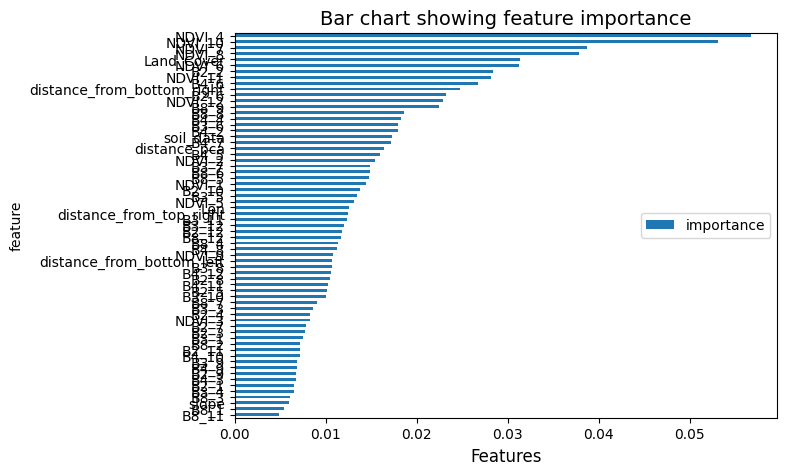

In [169]:

SEED = 2023
y = df_train['Target']
X = df_train.copy()
X = X[optimal_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
clf = RandomForestClassifier(100, random_state = SEED)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(list(X.columns))
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df.sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (7, 5))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()


In [158]:
# Generate test preds for submission

X = df_test[optimal_features]
y_pred_test = clf.predict(X)

result = pd.DataFrame({
    'ID': df_test['ID'],
    'Target': y_pred_test
})

result.to_csv('submission12mbothlc_moh.csv', index=False)


# Submission 2 -- Custom Ensemble method
Using almost all data to train with no testing.

## Here I use 8 different classification methods then a majarity vote will determind the class

In [ ]:
pip install catboost

In [162]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from collections import Counter
import numpy as np
X = df_train.drop(['Target', 'ID'], axis=1)
y = df_train['Target']
# Assuming X is your feature matrix and y is the target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[optimal_features], y, test_size=1, random_state=2023)

# Standardizing the data for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifiers = {
    'Random Forest': {'model': RandomForestClassifier(random_state=2023), 'scale': False},
    'Logistic Regression': {'model': LogisticRegression(random_state=2023), 'scale': True},
    'SVM': {'model': SVC(probability=True, random_state=2023), 'scale': True},
    'Gradient Boosting': {'model': GradientBoostingClassifier(random_state=2023), 'scale': False},
    'XGBoost': {'model': XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'), 'scale': False},
    'LightGBM': {'model': LGBMClassifier(random_state=2023), 'scale': False},
    'CatBoost': {'model': CatBoostClassifier(random_state=2023, verbose=0), 'scale': False},
    'Ridge Classifier': {'model': RidgeClassifier(random_state=2023), 'scale': True}
}

predictions = []
weights = []

# Train, predict, and get accuracy for each classifier
for name, clf_info in classifiers.items():
    clf = clf_info['model']
    scale = clf_info['scale']
    X_train_clf = X_train_scaled if scale else X_train
    X_test_clf = X_test_scaled if scale else X_test

    clf.fit(X_train_clf, y_train)
    pred = clf.predict(X_test_clf)
    acc = accuracy_score(y_test, pred)

    predictions.append(pred)
    weights.append(acc)

    print(f'{name} Accuracy: {acc}')

# Calculate the weighted majority vote
final_predictions = []
for i in range(len(X_test)):
    votes = []
    for j in range(len(classifiers)):
        votes.extend([predictions[j][i]] * int(weights[j] * 100))  # Multiply by 100 to convert weight to an integer

    vote_count = Counter(votes)
    final_predictions.append(vote_count.most_common(1)[0][0])

ensemble_accuracy = accuracy_score(y_test, final_predictions)
print(f'Ensemble Accuracy: {ensemble_accuracy}')


Random Forest Accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 1.0
SVM Accuracy: 1.0
Gradient Boosting Accuracy: 1.0
XGBoost Accuracy: 1.0
[LightGBM] [Info] Number of positive: 1499, number of negative: 1500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15568
[LightGBM] [Info] Number of data points in the train set: 2999, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499833 -> initscore=-0.000667
[LightGBM] [Info] Start training from score -0.000667
LightGBM Accuracy: 1.0
CatBoost Accuracy: 1.0
Ridge Classifier Accuracy: 1.0
Ensemble Accuracy: 1.0


In [163]:
from collections import Counter

def ensemble_predict(classifiers, X_test, weights):
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    # X_test_scaled = scaler.transform(X_test)
    predictions = []
    for name, clf_info in classifiers.items():
        clf = clf_info['model']
        scale = clf_info['scale']
        X_test_clf = X_test_scaled if scale else X_test
        pred = clf.predict(X_test_clf)
        predictions.append(pred)

    ensemble_predictions = []
    for i in range(len(X_test)):
        votes = []
        for j in range(len(classifiers)):
            votes.extend([predictions[j][i]] * int(weights[j] * 100))

        vote_count = Counter(votes)
        ensemble_predictions.append(vote_count.most_common(1)[0][0])

    return ensemble_predictions


X_test = df_test[optimal_features]

ensemble_predictions = ensemble_predict(classifiers, X_test, weights)

results_df = pd.DataFrame({
        'ID': df_test['ID'],
        'Target': ensemble_predictions
    })
results_df.to_csv('submission_ensemble_12bothlc_moh.csv', index=False)


# END